In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jlinops
import sampi

In [189]:
n_nonuniform = 150

y_uniform_true = jlinops.mixed_test_problem()
n = len(y_uniform_true)
x_uniform = np.linspace(0, 100, n)
np.random.seed(0)
noise_stdev = 0.1
noise_var = noise_stdev**2
x_nonuniform = np.sort(np.random.uniform(low=1e-3, high=100.0 - 1e-3, size=n_nonuniform))

# make regridding op
regridding_op = jlinops.LinearNonuniform2Uniform1DGriddingOperator( (0,100), n, x_nonuniform)

# Generate a noisy observation
y_nonuniform = regridding_op.matvec(y_uniform_true) + noise_stdev*np.random.normal(size=n_nonuniform)

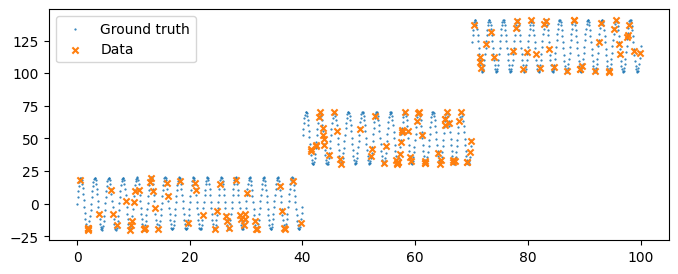

In [190]:
plt.figure(figsize=(8,3))
plt.scatter(x_uniform, y_uniform_true, label="Ground truth", color="C0", s=0.3)
plt.scatter(x_nonuniform, y_nonuniform, marker="x", label="Data", color="C1", alpha=1.0, s=20.0)
plt.legend()
plt.show()

# IAS reconstruction with first-order derivative

In [301]:
# Define forward operator and regularization matrix
F = regridding_op
Rmat, Wmat = jlinops.first_order_derivative_1d(n, boundary="none")
W = jlinops.MatrixLinearOperator(Wmat)
R = jlinops.MatrixLinearOperator(Rmat)

In [302]:
hyperparams = {
}

_Rpinv = jlinops.MatrixLinearOperator(np.linalg.pinv(R.A.toarray()))
Rpinv_factory = lambda theta: _Rpinv @ jlinops.DiagonalOperator(np.sqrt(theta))

# def Rpinv_factory(theta):
#     Rtilde = jlinops.MatrixLinearOperator(sps.diags(1.0/np.sqrt(theta)) @ Rmat)
#     return jlinops.BandedCholeskyPinvOperator(Rtilde, delta=1e-8)

pdata = {
    "W": W,
    "Rpinv_factory": Rpinv_factory,
}

In [386]:
# Prior parameters
reg_lambda = 0.743*1e1
vartheta = 2/(reg_lambda**2)
hyperparams = {
    "prior": {
        "r": 1.0,
        "beta": 1.5 + 1e-2,
        "vartheta": vartheta,
    },
    # "prior": {
    #     "r": -1.0,
    #     "beta": 1.0,
    #     "vartheta": 1e5,
    # },
    "noise_var": {
        "r": -1.0,
        "beta": 1,
        "vartheta": 1e-4,
    }
}

# Create solver
solver = sampi.IASSolver(F, R, y_nonuniform, hyperparams, noise_var=None, pdata=pdata)

In [387]:
data = solver.solve(max_iters=100, x0=y_uniform_true, priorconditioning=True, early_stopping=True, warmstarting=True, eps=1e-3)
y_uniform_recovered = data["x"]

In [388]:
data["n_iters"]

22

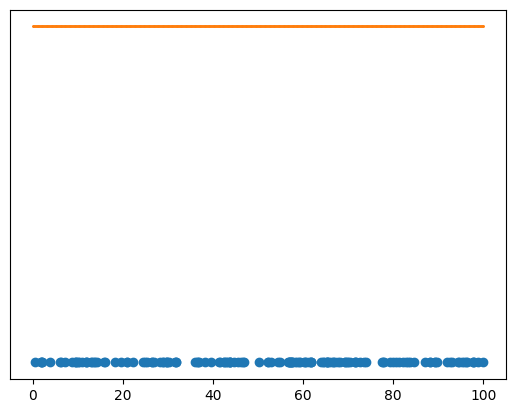

In [389]:
plt.scatter(x_nonuniform, np.ones_like(x_nonuniform), label="nonuniform gridpoints")
plt.scatter(x_uniform, 2*np.ones_like(x_uniform), s=0.5, label="uniform gridpoints")
plt.yticks([])
plt.show()

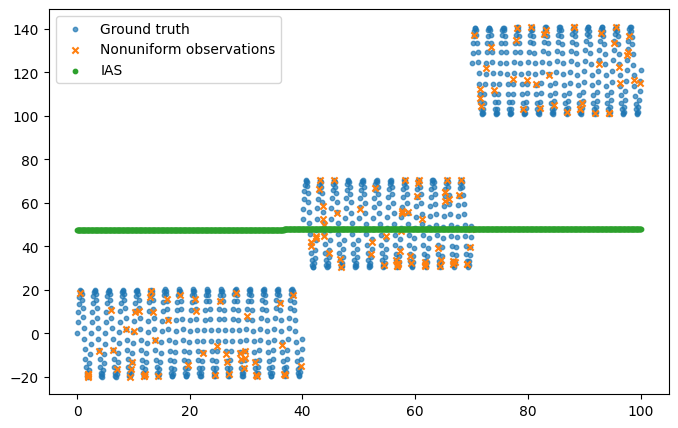

In [390]:
plt.figure(figsize=(8,5))
s = 10.0
plt.scatter(x_uniform, y_uniform_true, s=s, alpha=0.7, label="Ground truth")
plt.scatter(x_nonuniform, y_nonuniform, s=2*s, marker="x", label="Nonuniform observations")
plt.scatter(x_uniform, y_uniform_recovered, s=s, label="IAS")
plt.legend()
plt.show()

In [335]:
np.sqrt(data["noise_var"])

0.0011785534575712213

# Second order

In [392]:
# Define forward operator and regularization matrix
F = regridding_op
Rmat, Wmat = jlinops.second_order_derivative_1d(n, boundary="none")
W = jlinops.MatrixLinearOperator(Wmat)
R = jlinops.MatrixLinearOperator(Rmat)

In [393]:
hyperparams = {
}

_Rpinv = jlinops.MatrixLinearOperator(np.linalg.pinv(R.A.toarray()))
Rpinv_factory = lambda theta: _Rpinv @ jlinops.DiagonalOperator(np.sqrt(theta))

# def Rpinv_factory(theta):
#     Rtilde = jlinops.MatrixLinearOperator(sps.diags(1.0/np.sqrt(theta)) @ Rmat)
#     return jlinops.BandedCholeskyPinvOperator(Rtilde, delta=1e-8)

pdata = {
    "W": W,
    "Rpinv_factory": Rpinv_factory,
}

In [394]:
# Prior parameters
reg_lambda = 1e3
vartheta = 2/(reg_lambda**2)
hyperparams = {
    "prior": {
        "r": 1.0,
        "beta": 1.5 + 1e-2,
        "vartheta": vartheta,
    },
    #    "prior": {
    #     "r": -1.0,
    #     "beta": 1.0,
    #     "vartheta": 1e2,
    # },
    # "noise_var": {
    #     "r": -1.0,
    #     "beta": 1,
    #     "vartheta": 1e-4,
    # }
}

# Create solver
solver = sampi.IASSolver(F, R, y_nonuniform, hyperparams, noise_var=noise_var, pdata=pdata)

In [395]:
data = solver.solve(max_iters=1000, x0=y_uniform_true, priorconditioning=True, early_stopping=True, warmstarting=True, eps=1e-3)
y_uniform_recovered = data["x"]

In [396]:
data["n_iters"]

46

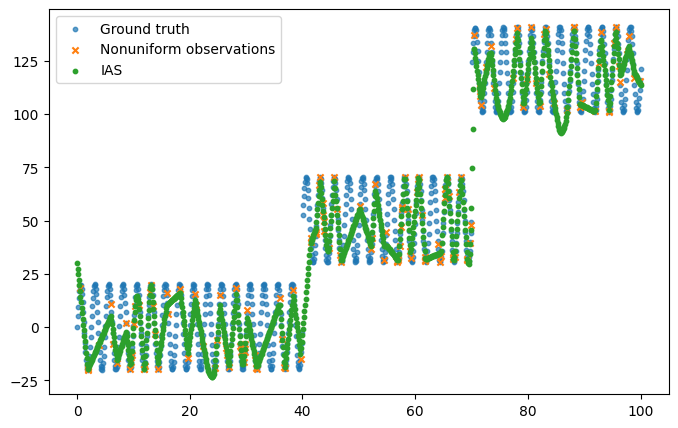

In [397]:
plt.figure(figsize=(8,5))
s = 10.0
plt.scatter(x_uniform, y_uniform_true, s=s, alpha=0.7, label="Ground truth")
plt.scatter(x_nonuniform, y_nonuniform, s=2*s, marker="x", label="Nonuniform observations")
plt.scatter(x_uniform, y_uniform_recovered, s=s, label="IAS")
plt.legend()
plt.show()

# Third order

In [398]:
# Define forward operator and regularization matrix
F = regridding_op
Rmat, Wmat = jlinops.third_order_derivative_1d(n, boundary="none")
W = jlinops.MatrixLinearOperator(Wmat)
R = jlinops.MatrixLinearOperator(Rmat)

In [399]:
hyperparams = {
}

_Rpinv = jlinops.MatrixLinearOperator(np.linalg.pinv(R.A.toarray()))
Rpinv_factory = lambda theta: _Rpinv @ jlinops.DiagonalOperator(np.sqrt(theta))

# def Rpinv_factory(theta):
#     Rtilde = jlinops.MatrixLinearOperator(sps.diags(1.0/np.sqrt(theta)) @ Rmat)
#     return jlinops.BandedCholeskyPinvOperator(Rtilde, delta=1e-8)

pdata = {
    "W": W,
    "Rpinv_factory": Rpinv_factory,
}

In [409]:
# Prior parameters
reg_lambda = 1e1
vartheta = 2/(reg_lambda**2)
hyperparams = {
    "prior": {
        "r": 1.0,
        "beta": 1.5 + 1e-2,
        "vartheta": vartheta,
    },
    # "prior": {
    #     "r": -1.0,
    #     "beta": 1.0,
    #     "vartheta": 1e-3,
    # },
    "noise_var": {
        "r": -1.0,
        "beta": 1,
        "vartheta": 1e-2,
    }
}

# Create solver
solver = sampi.IASSolver(F, R, y_nonuniform, hyperparams, noise_var=None, pdata=pdata)

In [417]:
data = solver.solve(max_iters=30, x0=y_uniform_true, priorconditioning=True, early_stopping=True, warmstarting=True, eps=1e-3)
y_uniform_recovered = data["x"]

In [420]:
data["n_iters"]

30

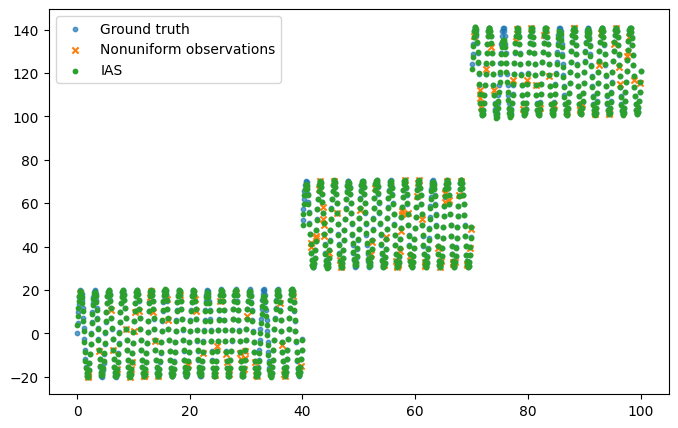

In [418]:
plt.figure(figsize=(8,5))
s = 10.0
plt.scatter(x_uniform, y_uniform_true, s=s, alpha=0.7, label="Ground truth")
plt.scatter(x_nonuniform, y_nonuniform, s=2*s, marker="x", label="Nonuniform observations")
plt.scatter(x_uniform, y_uniform_recovered, s=s, label="IAS")
plt.legend()
plt.show()

In [421]:
data["noise_var"]

0.0015664284044195787